Epoch [1/50], Step [100/938], D Loss: 0.5748, G Loss: 1.3448
FID: 647.2567
Epoch [1/50], Step [200/938], D Loss: 0.4503, G Loss: 1.1605
FID: 616.2471
Epoch [1/50], Step [300/938], D Loss: 0.3562, G Loss: 3.2843
FID: 408.9083
Epoch [1/50], Step [400/938], D Loss: 0.0791, G Loss: 6.7568
FID: 602.2599
Epoch [1/50], Step [500/938], D Loss: 0.1233, G Loss: 5.1003
FID: 470.4412
Epoch [1/50], Step [600/938], D Loss: 0.0291, G Loss: 5.4028
FID: 423.5274
Epoch [1/50], Step [700/938], D Loss: 0.3376, G Loss: 7.4293
FID: 531.3765
Epoch [1/50], Step [800/938], D Loss: 0.1466, G Loss: 5.4422
FID: 414.7112
Epoch [1/50], Step [900/938], D Loss: 0.0059, G Loss: 6.0149
FID: 601.1077
Epoch [2/50], Step [100/938], D Loss: 0.2944, G Loss: 11.1232
FID: 494.9936
Epoch [2/50], Step [200/938], D Loss: 0.0071, G Loss: 7.7391
FID: 442.9451
Epoch [2/50], Step [300/938], D Loss: 0.1479, G Loss: 7.8102
FID: 389.4808
Epoch [2/50], Step [400/938], D Loss: 0.1129, G Loss: 7.9179
FID: 271.7622
Epoch [2/50], Step [500/

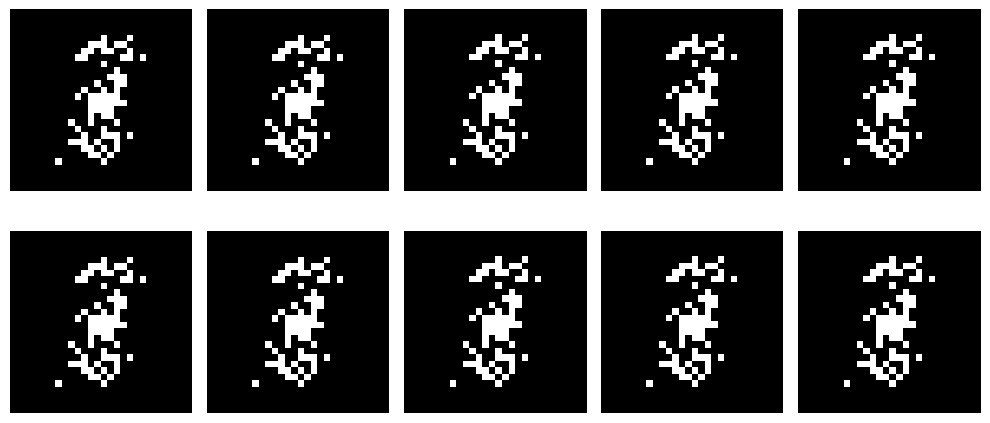

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim, signal_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + signal_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Assuming the output is a normalized image
        )
        
    def forward(self, noise, signal):
        combined_input = torch.cat((noise, signal), 1)
        return self.main(combined_input)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, signal_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + signal_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of being real
        )
        
    def forward(self, sample, signal):
        combined_input = torch.cat((sample, signal), 1)
        return self.main(combined_input)

# Parameters
batch_size = 64
signal_dim = 10
noise_dim = 100  # size of the g's input noise vector
image_dim = 28*28  # flatten MNIST
learning_rate = 0.0002

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize MNIST 
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(input_dim=noise_dim, signal_dim=signal_dim, output_dim=image_dim)
D = Discriminator(input_dim=image_dim, signal_dim=signal_dim)

optimizer_G = optim.Adam(G.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate)

# Training Loop
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

G.to(device)
D.to(device)

adversarial_loss = torch.nn.BCELoss()

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device) # flatten

        # create labels for real and fake
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # generate random noise + signals
        noise = torch.randn(batch_size, noise_dim, device=device)
        signals = torch.randn(batch_size, signal_dim, device=device)

        # use G to get fake images
        fake_images = G(noise, signals)

        # D train
        D_real = D(real_images, signals)
        D_fake = D(fake_images, signals)
        D_loss_real = adversarial_loss(D_real, real_labels)
        D_loss_fake = adversarial_loss(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # G train
        fake_images = G(noise, signals)
        D_fake = D(fake_images, signals)
        G_loss = adversarial_loss(D_fake, real_labels)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                    f'D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}')
                    
        # FID calculation for generated MNIST images
        if (i+1) % 100 == 0:
            mu1, sigma1 = torch.mean(real_images, dim=0), torch.std(real_images, dim=0)
            mu2, sigma2 = torch.mean(fake_images, dim=0), torch.std(fake_images, dim=0)
            FID = ((mu1 - mu2)**2 + (sigma1 - sigma2)**2).sum().item()
            print(f'FID: {FID:.4f}')

def show_generated_images(generator, noise_dim, signal_dim, num_images=10):
    noise = torch.randn(num_images, noise_dim, device=device)
    signals = torch.randn(num_images, signal_dim, device=device)
    with torch.no_grad():
        generated_images = generator(noise, signals).cpu().view(num_images, 28, 28)

    plt.figure(figsize=(10, 5))
    for i, image in enumerate(generated_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_generated_images(G, noise_dim, signal_dim)

